In [24]:
import mesa


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N):
        self.num_agents = N
        self.schedule = mesa.time.RandomActivation(self)
        #print(self.schedule)
        # Create agents
        for i in range(self.num_agents):
            #print(i)
            a = MoneyAgent(i, self)
            #print(a)
            self.schedule.add(a)
            #print(self.schedule)

    def step(self):
        """Advance the model by one step."""
        self.schedule.step()

In [29]:
model = MoneyModel(10)
for i in range(10):
    model.step()

(array([4., 0., 0., 3., 0., 0., 2., 0., 0., 1.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

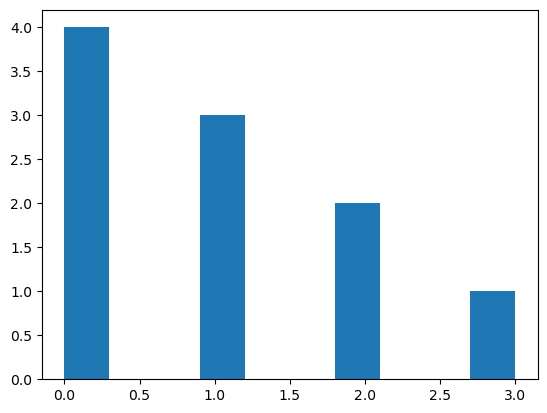

In [30]:
# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt

agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

(array([437., 298., 158.,  59.,  36.,  12.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <BarContainer object of 6 artists>)

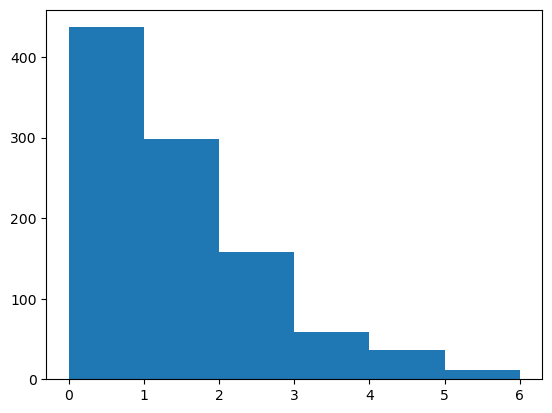

In [34]:
all_wealth = []
# This runs the model 100 times, each model executing 10 steps.
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        #print(agent.wealth)
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth) + 1))

In [36]:
len(all_wealth )

1000

In [37]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.schedule.step()

In [38]:
model = MoneyModel(50, 10, 10)
for i in range(20):
    model.step()

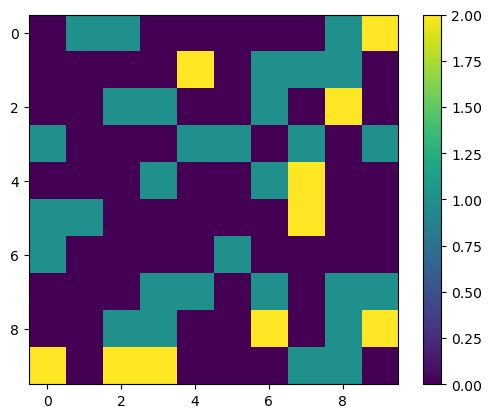

In [39]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation="nearest")
plt.colorbar()

In [54]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [52]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

<AxesSubplot:>

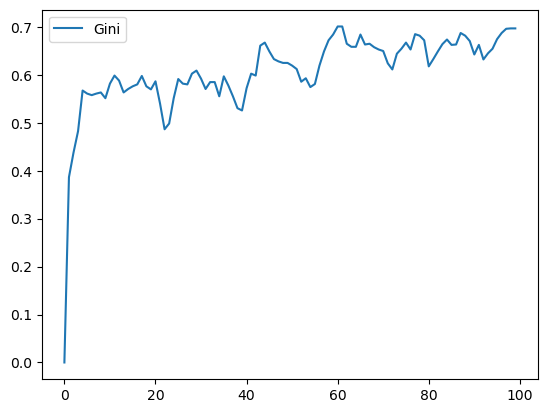

In [42]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [43]:
gini

,Gini
0,0.0000
1,0.3864
2,0.4376
3,0.4824
4,0.5672
...,...
95,0.6744
96,0.6872
97,0.6960
98,0.6968


In [44]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

In [45]:
agent_wealth.columns

Index(['Wealth'], dtype='object')

In [46]:
agent_wealth.index

MultiIndex([( 0,  0),
            ( 0,  1),
            ( 0,  2),
            ( 0,  3),
            ( 0,  4),
            ( 0,  5),
            ( 0,  6),
            ( 0,  7),
            ( 0,  8),
            ( 0,  9),
            ...
            (99, 40),
            (99, 41),
            (99, 42),
            (99, 43),
            (99, 44),
            (99, 45),
            (99, 46),
            (99, 47),
            (99, 48),
            (99, 49)],
           names=['Step', 'AgentID'], length=5000)

<AxesSubplot:>

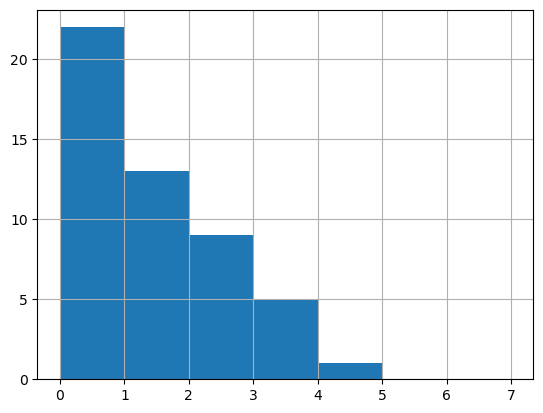

In [49]:
end_wealth = agent_wealth.xs(10, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max() + 1))

<AxesSubplot:xlabel='Step'>

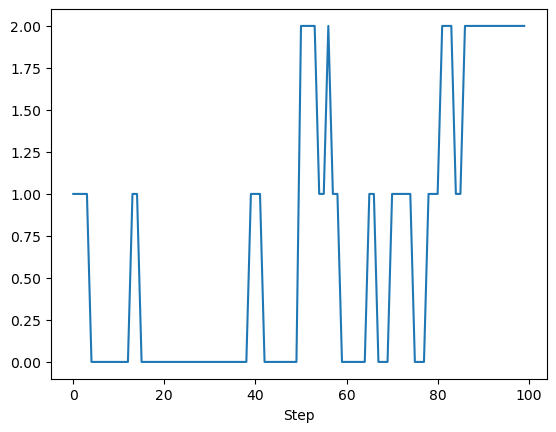

In [50]:
one_agent_wealth = agent_wealth.xs(14, level="AgentID")
one_agent_wealth.Wealth.plot()

In [82]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()        

In [57]:
params = {"width": 10, "height": 10, "N": range(10, 500, 10)}

results = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=5,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

100%|██████████| 245/245 [01:09<00:00,  3.52it/s]


In [ ]:
from multiprocessing import freeze_support

params = {"width": 10, "height": 10, "N": range(10, 500, 10)}

if __name__ == '__main__':
    freeze_support()
    results = mesa.batch_run(
            MoneyModel,
            parameters=params,
            iterations=5,
            max_steps=100,
            number_processes=None,
            data_collection_period=1,
            display_progress=True,
    )

  0%|          | 0/245 [00:00<?, ?it/s]

In [58]:
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'N', 'Gini', 'AgentID',
       'Wealth'],
      dtype='object')


In [64]:
results_df

,RunId,iteration,Step,width,height,N,Gini,AgentID,Wealth
0,0,0,0,10,10,10,0.000000,0,1
1,0,0,0,10,10,10,0.000000,1,1
2,0,0,0,10,10,10,0.000000,2,1
3,0,0,0,10,10,10,0.000000,3,1
4,0,0,0,10,10,10,0.000000,4,1
...,...,...,...,...,...,...,...,...,...
6186245,244,4,100,10,10,490,0.658201,485,0
6186246,244,4,100,10,10,490,0.658201,486,0
6186247,244,4,100,10,10,490,0.658201,487,3
6186248,244,4,100,10,10,490,0.658201,488,1


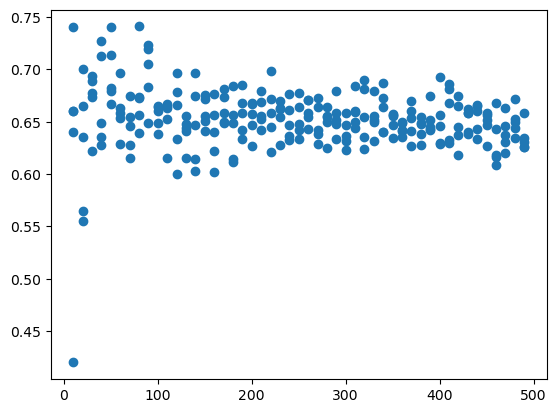

In [67]:
results_filtered = results_df[(results_df.AgentID ==4) & (results_df.Step == 100)]
N_values = results_filtered.N.values
gini_values = results_filtered.Gini.values
plt.scatter(N_values, gini_values)

In [68]:
# First, we filter the results
one_episode_wealth = results_df[(results_df.N == 10) & (results_df.iteration == 2)]
# Then, print the columns of interest of the filtered data frame
print(
    one_episode_wealth.to_string(
        index=False, columns=["Step", "AgentID", "Wealth"], max_rows=25
    )
)

 Step  AgentID  Wealth
    0        0       1
    0        1       1
    0        2       1
    0        3       1
    0        4       1
    0        5       1
    0        6       1
    0        7       1
    0        8       1
    0        9       1
    1        0       1
    1        1       1
  ...      ...     ...
   99        8       0
   99        9       1
  100        0       0
  100        1       0
  100        2       1
  100        3       1
  100        4       1
  100        5       2
  100        6       2
  100        7       2
  100        8       0
  100        9       1


In [69]:
results_one_episode = results_df[
    (results_df.N == 10) & (results_df.iteration == 1) & (results_df.AgentID == 0)
]
print(results_one_episode.to_string(index=False, columns=["Step", "Gini"], max_rows=25))

 Step  Gini
    0  0.00
    1  0.18
    2  0.18
    3  0.18
    4  0.18
    5  0.18
    6  0.32
    7  0.32
    8  0.42
    9  0.42
   10  0.42
   11  0.42
  ...   ...
   89  0.70
   90  0.70
   91  0.70
   92  0.70
   93  0.70
   94  0.70
   95  0.70
   96  0.66
   97  0.66
   98  0.66
   99  0.66
  100  0.66


In [70]:
results_one_episode = results_df[
    (results_df.N == 10) & (results_df.iteration == 1) & (results_df.AgentID == 0)
]
print(results_one_episode.to_string(index=False, columns=["Step", "Gini"], max_rows=25))

 Step  Gini
    0  0.00
    1  0.18
    2  0.18
    3  0.18
    4  0.18
    5  0.18
    6  0.32
    7  0.32
    8  0.42
    9  0.42
   10  0.42
   11  0.42
  ...   ...
   89  0.70
   90  0.70
   91  0.70
   92  0.70
   93  0.70
   94  0.70
   95  0.70
   96  0.66
   97  0.66
   98  0.66
   99  0.66
  100  0.66


In [81]:
"""
The full code should now look like:
"""
# from MoneyModel import *
import mesa


def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.5}

    if agent.wealth > 0:
        portrayal["Color"] = "red"
        portrayal["Layer"] = 0
    else:
        portrayal["Color"] = "grey"
        portrayal["Layer"] = 1
        portrayal["r"] = 0.2
    return portrayal


chart = mesa.visualization.ChartModule([{"Label": "Gini",
                      "Color": "Black"}],
                    data_collector_name='datacollector')

server = mesa.visualization.ModularServer(MoneyModel,
                       [grid, chart],
                       "Money Model",
                       {"N":100, "width":10, "height":10})

server.port = 8520  # The default
server.launch()

Interface starting at http://127.0.0.1:8520


RuntimeError: This event loop is already running

Socket opened!
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}


In [1]:
True+True

2

In [2]:
True+False

1

In [3]:
False+False

0

In [1]:
import logging
from urllib.parse import urljoin
import requests
from bs4 import BeautifulSoup

logging.basicConfig(
    format='%(asctime)s %(levelname)s:%(message)s',
    level=logging.INFO)

class Crawler:

    def __init__(self, urls=[]):
        self.visited_urls = []
        self.urls_to_visit = urls

    def download_url(self, url):
        return requests.get(url).text

    def get_linked_urls(self, url, html):
        soup = BeautifulSoup(html, 'html.parser')
        for link in soup.find_all('a'):
            path = link.get('href')
            if path and path.startswith('/'):
                path = urljoin(url, path)
            yield path

    def add_url_to_visit(self, url):
        if url not in self.visited_urls and url not in self.urls_to_visit:
            self.urls_to_visit.append(url)

    def crawl(self, url):
        html = self.download_url(url)
        for url in self.get_linked_urls(url, html):
            self.add_url_to_visit(url)

    def run(self):
        while self.urls_to_visit:
            url = self.urls_to_visit.pop(0)
            logging.info(f'Crawling: {url}')
            try:
                self.crawl(url)
            except Exception:
                logging.exception(f'Failed to crawl: {url}')
            finally:
                self.visited_urls.append(url)
                
    
url_root='https://e4ftl01.cr.usgs.gov/MOTA/MCD12Q1.006/2020.01.01'
#Crawler(urls=[url_root]).run()    #https://e4ftl01.cr.usgs.gov/MOTA/MCD12Q1.006/2020.01.01/MCD12Q1.A2020001.h31v07.006.2021359221355.hdf

In [13]:
import requests
from lxml import etree

resp=requests.get(url_root)

In [7]:
import os
tile = 'MCD19A1.A2020246.h08v05.006.2020270073445'
url = fr'https://e4ftl01.cr.usgs.gov/MOTA/MCD19A1.006/2020.09.02/{tile}.hdf'

username = 'richiebao_siniticink'
password = 'Lfyh0322' 

login = os.getenv('user')
password = os.getenv('pwd')
r = requests.get(url, verify=True, stream=True,auth=(login,password))
open(f'G:/temp/{tile}.hdf',"wb").write(r.content)

27

In [5]:
from modis_tools.auth import ModisSession
from modis_tools.resources import CollectionApi, GranuleApi
from modis_tools.granule_handler import GranuleHandler

In [14]:
username = 'richiebao_siniticink'# Update this line
password ='Lfyh0322'   # Update this line

# Authenticate a session
session = ModisSession(username=username, password=password)

# Query the MODIS catalog for collections
collection_client = CollectionApi(session=session)
collections = collection_client.query(short_name="MOD13A1", version="006")

# Query the selected collection for granules
granule_client = GranuleApi.from_collection(collections[0], session=session)

# Filter the selected granules via spatial and temporal parameters
nigeria_bbox = [2.1448863675, 4.002583177, 15.289420717, 14.275061098]
nigeria_granules = granule_client.query(start_date="2018-12-31", end_date="2018-12-31", bounding_box=nigeria_bbox)

# Download the granules
GranuleHandler.download_from_granules(nigeria_granules, session)

Downloading:  50%|█████     | 2/4 [1:44:14<1:44:14, 3127.11s/file]


SSLError: HTTPSConnectionPool(host='e4ftl01.cr.usgs.gov', port=443): Max retries exceeded with url: //MODV6_Cmp_B/MOLT/MOD13A1.006/2018.12.19/MOD13A1.A2018353.h18v07.006.2019032133447.hdf (Caused by SSLError(SSLEOFError(8, 'EOF occurred in violation of protocol (_ssl.c:1131)')))

pip install ndg-httpsclient

pip install pyopenssl

pip install pyasn1